<a href="https://colab.research.google.com/github/Shubham2004yadav/temp/blob/main/LLPS_vs_non_LLPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Zhou-Yetong/Opt_PredLLPS.git

Cloning into 'Opt_PredLLPS'...
remote: Enumerating objects: 2559, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 2559 (delta 16), reused 0 (delta 0), pack-reused 2532 (from 1)
Receiving objects: 100% (2559/2559), 77.39 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (419/419), done.
Updating files: 100% (80/80), done.


In [2]:
!ls Opt_PredLLPS/datasets
!pip install biopython

Ind_Test_II_N.fasta  LLPS.fasta       PdPS_N.fasta	 SaPS_N.fasta
Ind_Test_II_P.fasta  LLPS_Part.fasta  PdPS_P.fasta	 SaPS_P.fasta
Ind_Test_I_N.fasta   LLPS_Self.fasta  PdPS_Test_N.fasta  SaPS_Test_N.fasta
Ind_Test_I_P.fasta   non_LLPS.fasta   PdPS_Test_P.fasta  SaPS_Test_P.fasta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.2 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/Zhou-Yetong/Opt_PredLLPS.git


fatal: destination path 'Opt_PredLLPS' already exists and is not an empty directory.


In [4]:
!ls Opt_PredLLPS/datasets


Ind_Test_II_N.fasta  LLPS.fasta       PdPS_N.fasta	 SaPS_N.fasta
Ind_Test_II_P.fasta  LLPS_Part.fasta  PdPS_P.fasta	 SaPS_P.fasta
Ind_Test_I_N.fasta   LLPS_Self.fasta  PdPS_Test_N.fasta  SaPS_Test_N.fasta
Ind_Test_I_P.fasta   non_LLPS.fasta   PdPS_Test_P.fasta  SaPS_Test_P.fasta


In [5]:
from Bio import SeqIO
import pandas as pd

# Load LLPS (positive) sequences
llps_records = list(SeqIO.parse("Opt_PredLLPS/datasets/LLPS.fasta", "fasta"))

# Load non-LLPS (negative) sequences
non_llps_records = list(SeqIO.parse("Opt_PredLLPS/datasets/non_LLPS.fasta", "fasta"))


In [6]:
# Convert to DataFrame
llps_df = pd.DataFrame({
    'sequence': [str(rec.seq) for rec in llps_records],
    'label': ['LLPS'] * len(llps_records)
})

non_llps_df = pd.DataFrame({
    'sequence': [str(rec.seq) for rec in non_llps_records],
    'label': ['non-LLPS'] * len(non_llps_records)
})

# Combine both
df = pd.concat([llps_df, non_llps_df], ignore_index=True)
df.sample(5)  # View random 5 rows


,sequence,label
74,GHMDLNMPAYVKFNYMAEREDELSLIKGTKVIVMEKSSDGWWRGSY...,LLPS
937,ASATWGAAYPACENNCRKKYDLCIRCQGKWAGKRGKCAAHCIIQKN...,non-LLPS
708,MEQLTTLPRLGDPGAMEPWALPAWQHWTQGQGCKPGDASASIAATP...,LLPS
360,MYIKRVIIKGFKTYRNETIIDNFSPHQNVIIGSNGSGKSNFFAAIR...,LLPS
690,MATDELASKLSRRLQMEGEGGEATEQPGLNGAAAAAAAEAPDETAQ...,LLPS


In [7]:
!pip install biopython


In [8]:

from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Define amino acid volume (Å^3) and polarity (Grantham scale) dictionaries
aa_volume = {
    'A':  88.6, 'R': 173.4, 'N': 114.1, 'D': 111.1, 'C': 108.5,
    'Q': 143.8, 'E': 138.4, 'G':  60.1, 'H': 153.2, 'I': 166.7,
    'L': 166.7, 'K': 168.6, 'M': 162.9, 'F': 189.9, 'P':  112.7,
    'S':  89.0, 'T':  116.1, 'W': 227.8, 'Y': 193.6, 'V':  140.0
}
aa_polarity = {
    'A':   8.1, 'R':  10.5, 'N':  11.6, 'D':  13.0, 'C':   5.5,
    'Q':  10.5, 'E':  12.3, 'G':   9.0, 'H':  10.4, 'I':   5.2,
    'L':   4.9, 'K':  11.3, 'M':   5.7, 'F':   5.2, 'P':   8.0,
    'S':   9.2, 'T':   8.6, 'W':   5.4, 'Y':   6.2, 'V':   5.9
}

def compute_features(seq):
    """Compute selected features for a protein sequence."""
    seq = seq.upper()
    analysis = ProteinAnalysis(seq)
    # Calculate features
    hydrophobicity = analysis.gravy()
    aromaticity = analysis.aromaticity()
    pI = analysis.isoelectric_point()
    net_charge = analysis.charge_at_pH(7.0)
    # Average side-chain volume and polarity
    vol = sum(aa_volume.get(aa, 0) for aa in seq) / len(seq)
    pol = sum(aa_polarity.get(aa, 0) for aa in seq) / len(seq)
    return pd.Series({
        'hydrophobicity': hydrophobicity,
        'aromaticity':    aromaticity,
        'pI':             pI,
        'net_charge':     net_charge,
        'volume':         vol,
        'polarity':       pol
    })

# Apply to each sequence
features_df = df['sequence'].apply(compute_features)
df = pd.concat([df, features_df], axis=1)
df.head()


,sequence,label,hydrophobicity,aromaticity,pI,net_charge,volume,polarity
0,MNRYLNRQRLYNMEEERNKYRGVMEPMSRMTMDFQGRYMDSQGRMV...,LLPS,-1.531073,0.172316,7.219711,1.206412,141.622316,8.865254
1,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,LLPS,-0.676471,0.052941,5.360792,-13.461000,128.677059,8.864902
2,MKRPKILSGKKKSWFCMASVFLLVVAFALSIVSNAMAATGSFDRES...,LLPS,-0.057539,0.058634,4.471774,-49.193444,120.860825,8.510438
3,MKFCLSVALLAVAMVMVNGQFFGAGPFNTAHHSAVSDAAAAHHDAA...,LLPS,-0.317098,0.103627,6.210365,-8.147830,122.208290,8.559067
4,SSATNRVSPTRSVLPANWRQELESLRNGNGSSSAASSAPAPARSSS...,LLPS,-0.753052,0.037559,11.615801,16.474254,117.691549,8.880282


In [9]:
df['label_enc'] = df['label'].map({'LLPS': 1, 'non-LLPS': 0})


In [10]:
X = df[['hydrophobicity','volume','polarity','aromaticity','pI','net_charge']]
y = df['label_enc']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=104, stratify=y)


In [12]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y)  # no random_state


In [13]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=104)
clf.fit(X_train, y_train)


DecisionTreeClassifier(random_state=104)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)



# Optional: detailed classification report
print(classification_report(y_test, y_pred, target_names=['non-LLPS','LLPS']))


Accuracy on test set: 0.84
Confusion matrix:
 [[132  28]
 [ 24 136]]
              precision    recall  f1-score   support

    non-LLPS       0.85      0.82      0.84       160
        LLPS       0.83      0.85      0.84       160

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320



In [15]:
# we are taking random state defined not varying , this fucrion is just for fidning the highest accuracy state

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

best_accuracy = 0
best_seed = None

for seed in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y)

    clf = DecisionTreeClassifier(random_state=seed)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if acc > best_accuracy:
        best_accuracy = acc
        best_seed = seed

print(f"Best accuracy: {best_accuracy:.2f} with seed: {best_seed}")



Best accuracy: 0.84 with seed: 104


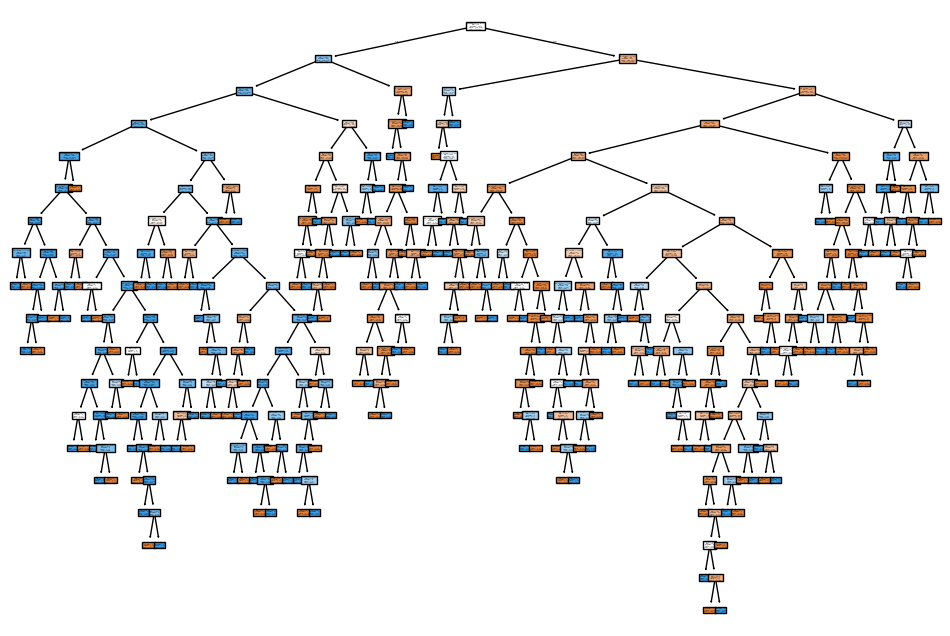

In [16]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=['non-LLPS','LLPS'], filled=True)
plt.show()


In [17]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Predefined property scales
aa_volume = {
    'A': 88.6, 'R': 173.4, 'N': 114.1, 'D': 111.1, 'C': 108.5,
    'Q': 143.8, 'E': 138.4, 'G': 60.1, 'H': 153.2, 'I': 166.7,
    'L': 166.7, 'K': 168.6, 'M': 162.9, 'F': 189.9, 'P': 112.7,
    'S': 89.0, 'T': 116.1, 'W': 227.8, 'Y': 193.6, 'V': 140.0
}
aa_polarity = {
    'A': 8.1, 'R': 10.5, 'N': 11.6, 'D': 13.0, 'C': 5.5,
    'Q': 10.5, 'E': 12.3, 'G': 9.0, 'H': 10.4, 'I': 5.2,
    'L': 4.9, 'K': 11.3, 'M': 5.7, 'F': 5.2, 'P': 8.0,
    'S': 9.2, 'T': 8.6, 'W': 5.4, 'Y': 6.2, 'V': 5.9
}

def compute_physicochemical_features(sequence):
    sequence = sequence.upper()
    analysis = ProteinAnalysis(sequence)

    features = {
        'hydrophobicity': analysis.gravy(),
        'aromaticity': analysis.aromaticity(),
        'volume': sum(aa_volume.get(aa, 0) for aa in sequence) / len(sequence),
        'polarity': sum(aa_polarity.get(aa, 0) for aa in sequence) / len(sequence),
        'pI': analysis.isoelectric_point(),
        'net_charge': analysis.charge_at_pH(7.0),
        'instability_index': analysis.instability_index(),
        'molecular_weight': analysis.molecular_weight()
    }
    return features


In [18]:
# Apply feature function to all sequences
feature_dicts = []
labels = []

for _, row in df.iterrows():
    seq = row['sequence']
    label = 1 if row['label'] == 'LLPS' else 0
    try:
        feats = compute_physicochemical_features(seq)
        feature_dicts.append(feats)
        labels.append(label)
    except Exception as e:
        print(f"Skipping sequence due to error: {e}")


In [19]:
features_df = pd.DataFrame(feature_dicts)
features_df['label'] = labels
features_df.head()


,hydrophobicity,aromaticity,volume,polarity,pI,net_charge,instability_index,molecular_weight,label
0,-1.531073,0.172316,141.622316,8.865254,7.219711,1.206412,74.041554,44120.5077,1
1,-0.676471,0.052941,128.677059,8.864902,5.360792,-13.461000,48.740980,55821.9442,1
2,-0.057539,0.058634,120.860825,8.510438,4.471774,-49.193444,17.301753,157998.5580,1
3,-0.317098,0.103627,122.208290,8.559067,6.210365,-8.147830,7.037824,20043.5288,1
4,-0.753052,0.037559,117.691549,8.880282,11.615801,16.474254,100.639906,21718.4258,1


In [20]:
# Dictionary format: {index: {'hydrophobicity': ..., 'volume': ..., ...}, ...}
feature_dictionary = features_df.drop(columns=['label']).to_dict(orient='index')


In [27]:
print(f"Analyzing {len(df)} proteins in the dataset")

Analyzing 1596 proteins in the dataset


In [21]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = features_df.drop(columns=['label']).values
y = features_df['label'].values

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# FDA (LDA)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)


In [23]:
import pandas as pd

# Suppose df is already defined and has a column 'sequence'
# Example:
# df = pd.DataFrame({'sequence': ['MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQANL...',
#                                 'GATRAGGATGAGGAGAGAGAGAGTGCTAGCTCCTG...',
#                                 ...],
#                    'label':   ['LLPS', 'non-LLPS', ...]})

# List the 20 standard amino acids in a fixed order
aa_list = ['A','C','D','E','F','G','H','I','K','L',
           'M','N','P','Q','R','S','T','V','W','Y']

def compute_aac_dict(sequence):
    """
    Given a protein sequence string, return a dict of
    normalized frequencies for each of the 20 amino acids.
    """
    seq = sequence.upper()
    length = len(seq)
    # Initialize counts to zero for each amino acid
    counts = {aa: 0 for aa in aa_list}
    # Count occurrences
    for aa in seq:
        if aa in counts:
            counts[aa] += 1
    # Normalize by length to get frequency
    aac = {aa: counts[aa] / length for aa in aa_list}
    return aac

# Build the full dictionary for all rows in df
aac_dict = {}
for idx, row in df.iterrows():
    seq = row['sequence']
    aac_dict[idx] = compute_aac_dict(seq)

# Example: print AAC for the first 3 proteins
for i in range(100):
    print(f"Protein index {i}:")
    print(aac_dict[i])
    print()


Protein index 0:
{'A': 0.005649717514124294, 'C': 0.005649717514124294, 'D': 0.07627118644067797, 'E': 0.03672316384180791, 'F': 0.025423728813559324, 'G': 0.09887005649717515, 'H': 0.08757062146892655, 'I': 0.002824858757062147, 'K': 0.002824858757062147, 'L': 0.00847457627118644, 'M': 0.1384180790960452, 'N': 0.07344632768361582, 'P': 0.0480225988700565, 'Q': 0.059322033898305086, 'R': 0.10734463276836158, 'S': 0.059322033898305086, 'T': 0.005649717514124294, 'V': 0.011299435028248588, 'W': 0.02824858757062147, 'Y': 0.11864406779661017}

Protein index 1:
{'A': 0.08627450980392157, 'C': 0.01568627450980392, 'D': 0.06274509803921569, 'E': 0.050980392156862744, 'F': 0.021568627450980392, 'G': 0.050980392156862744, 'H': 0.023529411764705882, 'I': 0.03725490196078431, 'K': 0.045098039215686274, 'L': 0.056862745098039215, 'M': 0.0196078431372549, 'N': 0.045098039215686274, 'P': 0.049019607843137254, 'Q': 0.10196078431372549, 'R': 0.041176470588235294, 'S': 0.09215686274509804, 'T': 0.10196

Randomly selected amino acids: ['D', 'N', 'M', 'E', 'V']


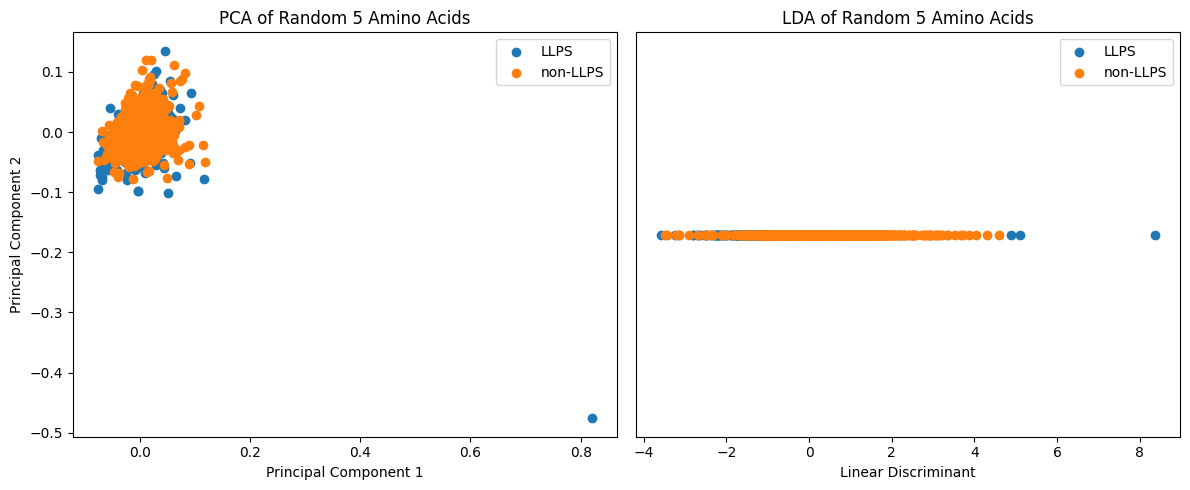

PCA explained variance ratio: [0.31664797 0.28251654]
LDA coefficients: [[ 5.25009705 -1.94574191 22.69583947  3.74631932 28.95137831]]


In [24]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import random

# Assuming df is already defined with 'sequence' and 'label' columns
# Example df:
# df = pd.DataFrame({
#     'sequence': ['MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQANL',
#                  'GATRAGGATGAGGAGAGAGAGAGTGCTAGCTCCTG',
#                  ...],
#     'label': ['LLPS', 'non-LLPS', ...]
# })

# List of 20 standard amino acids
aa_list = ['A','C','D','E','F','G','H','I','K','L',
           'M','N','P','Q','R','S','T','V','W','Y']

def compute_aac_dict(sequence):
    """Compute amino acid composition for a given sequence."""
    seq = sequence.upper()
    length = len(seq)
    counts = {aa: 0 for aa in aa_list}
    for aa in seq:
        if aa in counts:
            counts[aa] += 1
    return {aa: counts[aa]/length for aa in aa_list}

# Compute AAC for all sequences
aac_data = [compute_aac_dict(seq) for seq in df['sequence']]
aac_df = pd.DataFrame(aac_data, index=df.index)

# Randomly select 5 amino acids
random_aas = random.sample(aa_list, 5)
print("Randomly selected amino acids:", random_aas)

# Prepare data for analysis
X = aac_df[random_aas].values
y = df['label'].values

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# LDA (Fisher's Linear Discriminant)
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

# Plotting
plt.figure(figsize=(12, 5))

# PCA plot
plt.subplot(1, 2, 1)
for label in np.unique(y):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Random 5 Amino Acids')
plt.legend()

# LDA plot
plt.subplot(1, 2, 2)
for label in np.unique(y):
    plt.scatter(X_lda[y==label], np.zeros_like(X_lda[y==label]), label=label)
plt.xlabel('Linear Discriminant')
plt.yticks([])
plt.title('LDA of Random 5 Amino Acids')
plt.legend()

plt.tight_layout()
plt.show()

# Print explained variance for PCA
print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# Print LDA coefficients
print("LDA coefficients:", lda.coef_)

Evaluating 15504 combinations...


100%|██████████| 15504/15504 [01:00<00:00, 256.34it/s]



Top 10 performing 5-feature combinations:
1. Features: ('I', 'P', 'R', 'S', 'V') | Accuracy: 0.7863
2. Features: ('D', 'I', 'P', 'S', 'V') | Accuracy: 0.7851
3. Features: ('I', 'N', 'P', 'S', 'V') | Accuracy: 0.7838
4. Features: ('I', 'P', 'Q', 'S', 'V') | Accuracy: 0.7838
5. Features: ('I', 'P', 'S', 'V', 'W') | Accuracy: 0.7838
6. Features: ('G', 'I', 'P', 'S', 'V') | Accuracy: 0.7826
7. Features: ('I', 'M', 'P', 'S', 'V') | Accuracy: 0.7826
8. Features: ('A', 'I', 'P', 'S', 'V') | Accuracy: 0.7820
9. Features: ('C', 'I', 'P', 'S', 'V') | Accuracy: 0.7820
10. Features: ('I', 'Q', 'R', 'S', 'V') | Accuracy: 0.7820

Best 5-feature combination: ('I', 'P', 'R', 'S', 'V') with accuracy 0.7863

Average accuracy contribution of each amino acid:
S: 0.7271
P: 0.6769
V: 0.6738
I: 0.6729
Q: 0.6680
F: 0.6403
M: 0.6391
Y: 0.6389
W: 0.6389
H: 0.6389
C: 0.6383
T: 0.6382
N: 0.6352
R: 0.6319
L: 0.6292
D: 0.6227
A: 0.6225
E: 0.6224
K: 0.6220
G: 0.6078


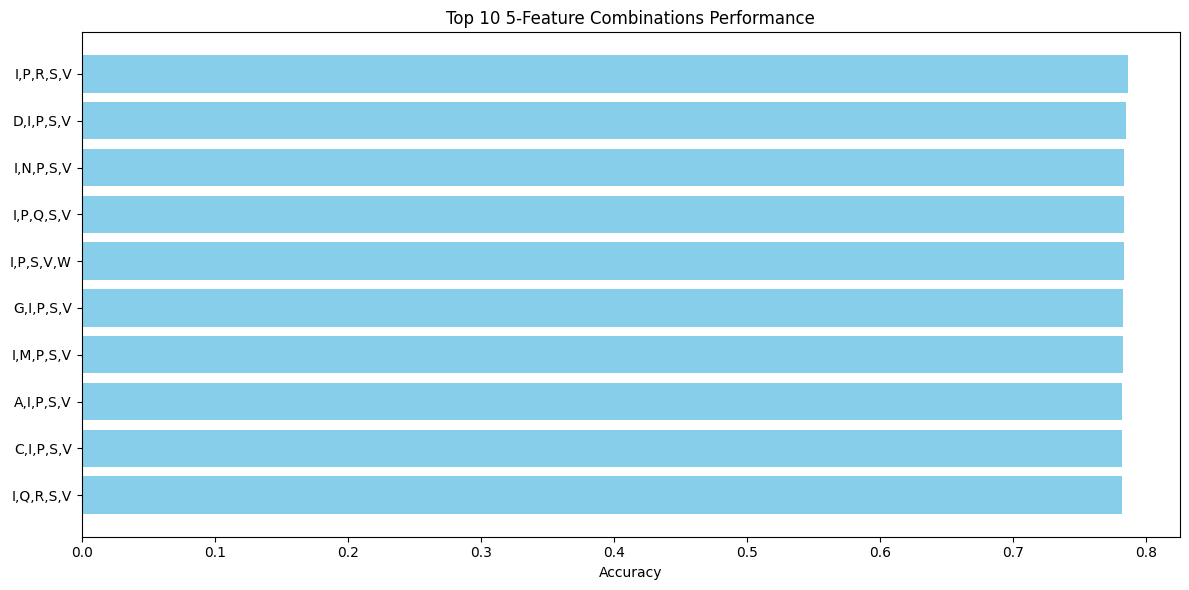

In [25]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # for progress bar

# Assuming df has 'sequence' and 'label' columns
aa_list = ['A','C','D','E','F','G','H','I','K','L',
           'M','N','P','Q','R','S','T','V','W','Y']

def compute_aac_dict(sequence):
    seq = sequence.upper()
    length = len(seq)
    counts = {aa: 0 for aa in aa_list}
    for aa in seq:
        if aa in counts:
            counts[aa] += 1
    return {aa: counts[aa]/length for aa in aa_list}

# Compute AAC for all sequences
aac_data = [compute_aac_dict(seq) for seq in df['sequence']]
aac_df = pd.DataFrame(aac_data, index=df.index)
X_all = aac_df[aa_list].values
y = df['label'].map({'LLPS': 1, 'non-LLPS': 0}).values  # Convert to binary

# Function to evaluate feature combination
def evaluate_features(features):
    X = aac_df[list(features)].values

    # PCA + LDA evaluation
    try:
        # Reduce to 2 components with PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # Apply LDA on PCA results
        lda = LDA()
        lda.fit(X_pca, y)
        X_lda = lda.transform(X_pca)

        # Get predictions
        y_pred = lda.predict(X_pca)
        acc = accuracy_score(y, y_pred)

        # Return both accuracy and the features
        return acc, features
    except:
        # In case of any error (e.g., when LDA fails)
        return 0.0, features

# Evaluate all possible 5-feature combinations
all_combinations = list(combinations(aa_list, 5))
results = []

print(f"Evaluating {len(all_combinations)} combinations...")
for combo in tqdm(all_combinations):
    acc, features = evaluate_features(combo)
    results.append((acc, features))

# Sort results by accuracy (descending)
results.sort(reverse=True, key=lambda x: x[0])

# Display top 10 combinations
print("\nTop 10 performing 5-feature combinations:")
for i, (acc, features) in enumerate(results[:10], 1):
    print(f"{i}. Features: {features} | Accuracy: {acc:.4f}")

# Best combination
best_acc, best_features = results[0]
print(f"\nBest 5-feature combination: {best_features} with accuracy {best_acc:.4f}")

# Generate accuracy matrix for all features
feature_performance = {aa: 0 for aa in aa_list}
for acc, features in results:
    for aa in features:
        feature_performance[aa] += acc

# Normalize by number of appearances
for aa in feature_performance:
    feature_performance[aa] /= len([1 for _, features in results if aa in features])

print("\nAverage accuracy contribution of each amino acid:")
for aa, score in sorted(feature_performance.items(), key=lambda x: -x[1]):
    print(f"{aa}: {score:.4f}")

# Visualize top combinations
import matplotlib.pyplot as plt

top_n = 10
top_accs = [acc for acc, _ in results[:top_n]]
top_feature_sets = [','.join(feats) for _, feats in results[:top_n]]

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_accs[::-1], color='skyblue')
plt.yticks(range(top_n), top_feature_sets[::-1])
plt.xlabel('Accuracy')
plt.title(f'Top {top_n} 5-Feature Combinations Performance')
plt.tight_layout()
plt.show()

In [26]:
print(f"Analyzing {len(df)} proteins in the dataset")

Analyzing 1596 proteins in the dataset


In [28]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# --- Load Data (Assuming df has 'sequence' and 'label') ---
aa_list = ['A','C','D','E','F','G','H','I','K','L',
           'M','N','P','Q','R','S','T','V','W','Y']

# --- Compute AAC (Amino Acid Composition) ---
def compute_aac(sequence):
    seq = sequence.upper()
    length = len(seq)
    return {aa: seq.count(aa)/length for aa in aa_list}

# Create AAC DataFrame
aac_data = [compute_aac(seq) for seq in df['sequence']]
aac_df = pd.DataFrame(aac_data)
y = df['label'].map({'LLPS': 1, 'non-LLPS': 0})  # Binary labels

# --- LDA Model ---
lda = LDA()

# --- Evaluate with 5-Fold Cross-Validation ---
cv_scores = cross_val_score(lda, aac_df, y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"LDA Mean Accuracy (5-Fold CV): {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# --- Train LDA on Full Data (for feature analysis) ---
lda.fit(aac_df, y)

# --- Get Feature Coefficients (Importance) ---
feature_importance = pd.DataFrame({
    'Amino Acid': aa_list,
    'LDA Coefficient': lda.coef_[0]
}).sort_values('LDA Coefficient', ascending=False)

print("\nTop Discriminative Amino Acids:")
print(feature_importance.head(10))

LDA Mean Accuracy (5-Fold CV): 0.7989 ± 0.0385

Top Discriminative Amino Acids:
   Amino Acid  LDA Coefficient
15          S        24.230293
13          Q        17.031128
12          P        15.732102
11          N        11.916336
3           E         5.041722
14          R         4.032734
16          T         3.396427
2           D         0.613859
8           K         0.418427
5           G        -0.698749


Testing combinations:   0%|          | 68/15504 [02:38<9:58:21,  2.33s/it]


KeyboardInterrupt: 

Top 10 Candidate Amino Acids: ['F', 'L', 'Y', 'C', 'W', 'Q', 'P', 'V', 'I', 'S']


Testing Top Combos:   0%|          | 1/252 [00:01<07:18,  1.75s/it]

New Best: ('F', 'C', 'W', 'V', 'S') | Accuracy: 0.7907


Testing Top Combos:   1%|          | 3/252 [00:04<06:32,  1.57s/it]

New Best: ('W', 'Q', 'P', 'I', 'S') | Accuracy: 0.7964


Testing Top Combos:  22%|██▏       | 55/252 [01:03<03:37,  1.10s/it]

New Best: ('Y', 'C', 'Q', 'I', 'S') | Accuracy: 0.7995


Testing Top Combos:  31%|███       | 78/252 [01:29<03:07,  1.07s/it]

New Best: ('L', 'C', 'V', 'I', 'S') | Accuracy: 0.8089


Testing Top Combos:  52%|█████▏    | 131/252 [02:29<02:27,  1.22s/it]

New Best: ('C', 'W', 'Q', 'I', 'S') | Accuracy: 0.8102


Testing Top Combos: 100%|██████████| 252/252 [04:45<00:00,  1.13s/it]



🔥 Best 5 Features: ('C', 'W', 'Q', 'I', 'S') | Accuracy: 0.8102


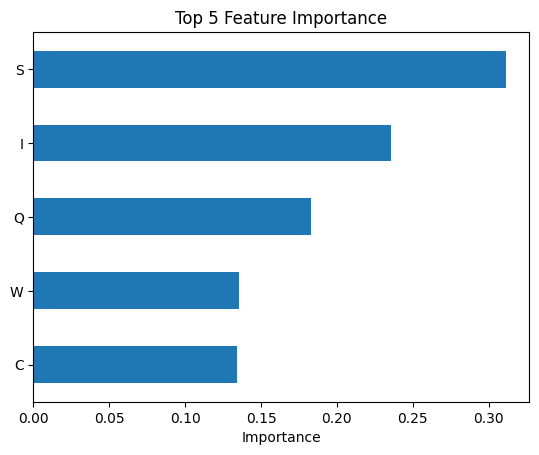

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import combinations
import random
from tqdm import tqdm

aa_list = ['A','C','D','E','F','G','H','I','K','L',
           'M','N','P','Q','R','S','T','V','W','Y']

def compute_aac(sequence):
    seq = sequence.upper()
    length = len(seq)
    return {aa: seq.count(aa)/length for aa in aa_list}

aac_data = [compute_aac(seq) for seq in df['sequence']]
aac_df = pd.DataFrame(aac_data)
y = df['label'].map({'LLPS': 1, 'non-LLPS': 0})

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(aac_df, y)

top_10_aa = aac_df.columns[np.argsort(clf.feature_importances_)[-10:]].tolist()
print(f"Top 10 Candidate Amino Acids: {top_10_aa}")

candidate_combos = list(combinations(top_10_aa, 5))
random.shuffle(candidate_combos)

best_acc = 0
best_combo = None

for combo in tqdm(candidate_combos[:500], desc="Testing Top Combos"):  # Early stop after 500
    X = aac_df[list(combo)]
    acc = cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean()  # 3-fold for speed
    if acc > best_acc:
        best_acc = acc
        best_combo = combo
        print(f"New Best: {combo} | Accuracy: {acc:.4f}")

print(f"\n🔥 Best 5 Features: {best_combo} | Accuracy: {best_acc:.4f}")
clf_final = RandomForestClassifier(n_estimators=200, random_state=42)
clf_final.fit(aac_df[list(best_combo)], y)

pd.Series(clf_final.feature_importances_, index=best_combo).sort_values().plot.barh()
plt.xlabel("Importance")
plt.title("Top 5 Feature Importance")
plt.show()